# Numerical results for the [Shorter Quantum Circuits](https://arxiv.org/abs/2203.10064) paper 

## Datasets overview

### List of datasets 

We provide numerical results for approximating diagonal rotation gates $\exp(i\phi Z)$ for the Clifford+$T$ 
and Clifford+$\sqrt{T}$ gate sets. The corresponding dataset files begin with the prefixes `clifford-t-` and `clifford-root-t-`.
For each gate set, we have two sets of target rotation angles: Fourier angles ($\phi = \frac{\pi}{2^n}$) and random angles.
The corresponding dataset file names end in `fourier-angles.tar.gz` and `random-angles.tar.gz`.
For each target angle, we construct a series of approximations with increasing diamond norm accuracies using the following protocols:

* diagonal approximation 
* fallback approximation
* mixed diagonal approximation 
* mixed fallback approximation

For a summary of the numerical results, refer to [Table 1](https://arxiv.org/pdf/2203.10064v1.pdf#page=6) in the paper. 
The dataset naming convention is `<gate-set>-<angles-kind>.tar.gz`

The next cell downloads the dataset and some helper files. 


In [ ]:
!curl "https://azure-quantum-notebooks.azurefd.net/publicdata/shorter-quantum-circuits-dataset.tar" --output shorter-quantum-circuits-dataset.tar
!tar -xf shorter-quantum-circuits-dataset.tar
!ls -l

### Dataset structure

#### Archive structure

Each dataset file is a `tar.gz` archive containing a set of JSON files. 
Each JSON file contains the result of approximating one diagonal rotation gate by a fixed target angle 
using one of the four approximation protocols. 
The name of each JSON file starts with a prefix representing the rotation angle using scientific notation, 
and ends with a suffix corresponding to the approximation protocol:

* `diagonal.json` for diagonal approximation 
* `fallback.json` for fallback approximation
* `mixed-diagonal.json` for mixed diagonal approximation 
* `mixed-fallback.json` for mixed fallback approximation

The naming convention for the JSON files is `<angle>-<protocol-kind>.json`. Each file contains a series of descriptions of the corresponding protocol with increasing diamond norm accuracy.

In [2]:
import tarfile
import itertools
with tarfile.open('clifford-root-t-fourier-angles.tar.gz') as tar:
    for member in itertools.islice(tar, 10):
        print(member.name)

0.00019175-diagonal.json
0.00019175-fallback.json
0.00019175-mixed-diagonal.json
0.00019175-mixed-fallback.json
0.00038350-diagonal.json
0.00038350-fallback.json
0.00038350-mixed-diagonal.json
0.00038350-mixed-fallback.json
0.00076699-diagonal.json
0.00076699-fallback.json


#### File structure

Each file contains an array $a_k$ of the best found approximation protocols that use a denominator power of at most $k$ in the branch that is applied with the highest probability. Each element of the array corresponds to one instance of the approximation protocol.

Each protocol instance description in the JSON file contains three keys:

* `target_angle` for the target rotation angle
* `protocol_name` for the protocol name
* `elements` for a description of the gate sequences and the probabilities with which these sequences are applied.

In [3]:
import tarfile
import json
with tarfile.open('clifford-root-t-fourier-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[2]).read().decode())
    print(f'{type(protocol_instances)} of length {len(protocol_instances)}')
    print("Example of a protocol instance:\n", json.dumps(protocol_instances[-1], indent=2))

<class 'list'> of length 91
Example of a protocol instance:
 {
  "target_angle": "0.00019174759848570515371476094868649309595929989009858",
  "protocol_name": "mixed diagonal",
  "elements": [
    {
      "gates": "Rx[2,16].Rz[1,16].Rx[1,16].Ry[2,16].Rz[2,16].Ry[3,16].Rz[2,16].Ry[1,16].Rx[2,16].Ry[2,16].Rz[2,16].Ry[2,16].Rx[2,16].Ry[2,16].Rx[2,16].Ry[2,16].Rz[1,16].Ry[2,16].Rx[2,16].Rz[2,16].Ry[3,16].Rz[2,16].Ry[1,16].Rz[3,16].Ry[2,16].Rz[3,16].Rx[2,16].Rz[1,16].Ry[3,16].Rx[2,16].Ry[1,16].Rz[1,16].Ry[2,16].Rx[2,16].Rz[3,16].Rx[1,16].Rz[2,16].H.S.H.I",
      "probability": "0.14665321510477780365602456755408950220880694827776",
      "apply_as": "twirl"
    },
    {
      "gates": "Rx[1,16].Ry[1,16].Rz[2,16].Rx[2,16].Rz[2,16].Rx[2,16].Rz[2,16].Ry[2,16].Rx[2,16].Ry[2,16].Rx[2,16].Rz[3,16].Rx[3,16].Rz[1,16].Rx[2,16].Rz[1,16].Rx[2,16].Ry[3,16].Rx[2,16].Rz[1,16].Ry[2,16].Rz[3,16].Ry[2,16].Rz[2,16].Ry[2,16].Rx[2,16].Rz[2,16].Ry[3,16].Rx[3,16].Ry[1,16].Rx[1,16].Rz[3,16].Ry[2,16].Rx[3,16].Rz[3

#### Protocol instance structure

The array corresponding to the key `element` of the protocol instance data structure is an array of length one, two, four, or six. 
Each array item contains three keys:
* `gates` - a string representing a product of unitary matrices $V$, for example `Rz[1,16].H.S` represents matrix product $V = \exp(-\frac{i\pi\cdot1}{16}Z)HS$
* `apply_as` - describes how the matrix product $V$ above is used in the protocol, one of `unitary`, `twirl`, or `projection`
* `probability` - $p$, floating point number between zero and one, the probability with which `gates` will be applied.

When `apply_as` is `unitary`, the product unitary $V$ directly applied to the target qubit on which rotation is to be executed.
When `apply_as` is `twirl`, one of the four unitaries $V$, $SVS^\dagger$, $ZVZ$, $(SZ)V(SZ)^\dagger$ 
is applied each with probability $p/4$. 
When `apply_as` is `projection`, the product unitary $V$ is applied to an ancillary qubit as a part of projective rotation circuit in 
[Figure 7](https://arxiv.org/pdf/2203.10064v1.pdf#page=19) in the paper shown below.

The projective rotation circuit is applied with probability $p$.
Next we discuss some protocol specific details.

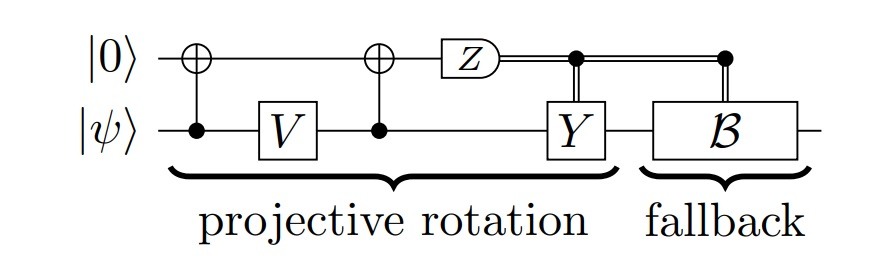

##### Diagonal approximation protocol

This is the simplest protocol where a unitary is approximated with a single sequence of gates. 
The array `elements` always contains one item, with `apply_as` being `unitary` and `probability` being 1.0 in the item.

In [4]:
import tarfile
import json
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[0]).read().decode())
    print(f'{type(protocol_instances)} of length {len(protocol_instances)}')
    print("Example of a diagonal approximation protocol instance:\n", json.dumps(protocol_instances[-1], indent=2))

<class 'list'> of length 181
Example of a diagonal approximation protocol instance:
 {
  "target_angle": "0.0085212081429389986115180481492109940442613466212046",
  "protocol_name": "diagonal",
  "elements": [
    {
      "gates": "Ry[1,16].Rx[2,16].Rz[1,16].Ry[2,16].Rx[2,16].Rz[3,16].Rx[2,16].Rz[2,16].Ry[3,16].Rx[2,16].Rz[1,16].Ry[2,16].Rz[2,16].Ry[2,16].Rx[1,16].Ry[1,16].Rx[1,16].Ry[3,16].Rx[3,16].Ry[3,16].Rz[3,16].Rx[2,16].Ry[1,16].Rx[2,16].Rz[2,16].Ry[2,16].Rx[1,16].Rz[2,16].Ry[1,16].Rx[3,16].Rz[2,16].Ry[1,16].Rx[2,16].Ry[2,16].Rz[3,16].Rx[2,16].Rz[2,16].Ry[2,16].Rx[2,16].Rz[2,16].Rx[2,16].Rz[2,16].Rx[2,16].Ry[2,16].Rz[2,16].Rx[1,16].Ry[1,16].Rx[1,16].Ry[2,16].Rz[1,16].Ry[1,16].Rz[3,16].Ry[3,16].Rz[2,16].Ry[2,16].Rx[3,16].Rz[3,16].Rx[3,16].Rz[1,16].Ry[1,16].Rx[3,16].Rz[2,16].Ry[1,16].Rx[2,16].Ry[2,16].Rz[2,16].Rx[2,16].Rz[2,16].Rx[3,16].Ry[1,16].Rx[1,16].Rz[3,16].S.I",
      "probability": "1.0000000000000000000000000000000000000000000000000",
      "apply_as": "unitary"
    }
  ]


##### Fallback approximation protocol

For this protocol, the array `elements` has one or two items and describes the circuit in [Figure 7](https://arxiv.org/pdf/2203.10064v1.pdf#page=19) of the paper shown below.

The first item describes a projective rotation with `apply_as` being `projection`, `probability` is 1.0, 
that is the fallback circuit measurement outcome is zero. 
If the success probability of projective rotation is one, the second item is omitted.
The second item describes a "fallback" unitary that must be applied to target qubits in order to recover from failure, that is when the measurement outcome is one.
The probability for the second item is equal to the probability of the projective rotation failure.
For the second item `apply_as` is `unitary` and channel $\mathcal{B}$ in the picture above is a unitary channel.

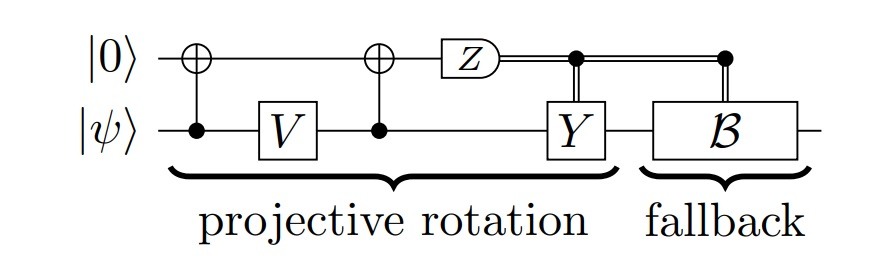

In [5]:
import tarfile
import json
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[1]).read().decode())
    print("Example of a fallback approximation protocol instance:\n", json.dumps(protocol_instances[-1], indent=2))

Example of a fallback approximation protocol instance:
 {
  "target_angle": "0.0085212081429389986115180481492109940442613466212046",
  "protocol_name": "fallback",
  "elements": [
    {
      "gates": "Rx[3,16].Ry[3,16].Rz[3,16].Ry[2,16].Rz[1,16].Rx[2,16].Rz[1,16].Ry[1,16].Rz[2,16].Rx[1,16].Rz[2,16].Rx[3,16].Rz[2,16].Rx[2,16].Rz[2,16].Ry[1,16].Rz[3,16].Rx[2,16].Ry[2,16].Rx[3,16].Ry[1,16].Rz[2,16].Rx[3,16].I.Y.I",
      "probability": 1.0,
      "apply_as": "projection"
    },
    {
      "gates": "Rx[1,16].Ry[1,16].Rz[2,16].Ry[1,16].Rx[1,16].Rz[2,16].Rx[1,16].Ry[1,16].Rx[2,16].Ry[2,16].Rz[3,16].Rx[1,16].Ry[1,16].Rx[1,16].Rz[1,16].Rx[2,16].Rz[1,16].Rx[2,16].Ry[2,16].Rx[2,16].Ry[1,16].Rz[3,16].Rx[2,16].Ry[3,16].Rx[3,16].Rz[3,16].Ry[3,16].Rz[1,16].Ry[2,16].Rz[3,16].Ry[2,16].Rz[2,16].Rx[1,16].Ry[3,16].Rx[2,16].Ry[2,16].Rx[1,16].Rz[2,16].Rx[1,16].Ry[1,16].Rz[2,16].Ry[2,16].Rz[1,16].Rx[3,16].Rz[2,16].Ry[2,16].Rx[3,16].Ry[1,16].Rx[2,16].Ry[1,16].Rz[2,16].Rx[2,16].Ry[2,16].Rz[2,16].Ry[2,16].R

##### Mixed diagonal approximation protocol

Mixed diagonal approximation contains an `elements` array with two items that together define
the product unitaries $V_1$, $V_2$ and probabilities $p_1,p_2$ where $p_1 + p_2 = 1$. 
For both items `apply_as` is `twirl`.
The protocol applies the $S,Z$-twirl of unitary $V_1$ with probability $p_1$ and the $S,Z$-twirl 
of unitary $V_2$ with probability $p_2$. 
In other words, the protocol applies one of the eight unitaries related to $V_1,V_2$ with probabilities $\frac{p_1}{4},\frac{p_1}{4},\frac{p_1}{4},\frac{p_1}{4},\frac{p_2}{4},\frac{p_2}{4},\frac{p_2}{4},\frac{p_2}{4}$.

In [6]:
import tarfile
import json
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[2]).read().decode())
    print("Example of a mixed diagonal approximation protocol instance:\n", json.dumps(protocol_instances[-1],indent=2))

Example of a mixed diagonal approximation protocol instance:
 {
  "target_angle": "0.0085212081429389986115180481492109940442613466212046",
  "protocol_name": "mixed diagonal",
  "elements": [
    {
      "gates": "Rx[2,16].Rz[3,16].Rx[1,16].Rz[2,16].Rx[2,16].Ry[2,16].Rz[3,16].Rx[2,16].Ry[2,16].Rx[3,16].Rz[2,16].Rx[1,16].Rz[3,16].Rx[2,16].Ry[2,16].Rz[3,16].Rx[1,16].Rz[2,16].Ry[3,16].Rx[2,16].Ry[1,16].Rz[2,16].Rx[2,16].Ry[3,16].Rz[2,16].Ry[3,16].Rx[2,16].Rz[2,16].Ry[1,16].Rz[2,16].Ry[3,16].Rx[2,16].Ry[1,16].Rx[2,16].Rz[2,16].Ry[3,16].H.S.X.I",
      "probability": "0.011995270930396363027978198076045727786371866397820",
      "apply_as": "twirl"
    },
    {
      "gates": "Rz[3,16].Rx[2,16].Ry[3,16].Rx[2,16].Rz[2,16].Ry[1,16].Rz[2,16].Ry[1,16].Rz[2,16].Rx[1,16].Rz[1,16].Rx[3,16].Ry[3,16].Rx[2,16].Rz[2,16].Ry[3,16].Rz[2,16].Rx[1,16].Rz[2,16].Ry[2,16].Rx[2,16].Rz[3,16].Ry[3,16].Rx[2,16].Rz[3,16].Rx[2,16].Rz[2,16].Rx[1,16].Rz[1,16].Ry[2,16].Rz[2,16].Rx[3,16].Ry[2,16].Rx[2,16].Ry[3,16].Rx[

##### Mixed fallback approximation protocol

The first item in the `elements` array describes a projective rotation that is applied with probability `probability` denoted as $p_1$. 

If the probability of success of the projective rotation is less then one, then
the next two items describe 
a mixed diagonal protocol that is applied if the projective rotation fails. 
Denote probabilities in the second and third items as $p_2$ and $p_3$. Their sum is equal to $p_1 p_{\textrm{fail}}$ 
where $p_{\textrm{fail}}$ is the probability of the failure of the projective rotation. 
When implementing the protocol on a quantum computer, 
the twirls in the second and third items should be applied with probabilities $p_2/(p_2+p_3)$ and $p_3/(p_2+p_3)$. 

If the success probability of the first projective rotation is one then the description of 
a mixed diagonal protocol to be applied upon failure is omitted.

The next item describes a second projective rotation that is applied with probability `probability` denoted as $q_1$ and such that $p_1 + q_1 = 1$. 
Similarly, if the probability of success of the projective rotation is less then one,
the next two items describe mixed diagonal protocol. Otherwise, the next two items are omitted.

In [7]:
import tarfile
import json
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[3]).read().decode())
    print("Example of a mixed diagonal approximation protocol instance:\n", json.dumps(protocol_instances[-3], indent=2))

Example of a mixed diagonal approximation protocol instance:
 {
  "target_angle": "0.0085212081429389986115180481492109940442613466212046",
  "protocol_name": "mixed fallback",
  "elements": [
    {
      "gates": "Rz[1,16].Rx[2,16].Rz[3,16].Ry[2,16].Rx[1,16].Rz[2,16].Ry[1,16].Rz[2,16].Ry[3,16].Rz[3,16].Rx[2,16].S.H.Z.I",
      "probability": "0.33642091395774735868734582922604655774353128049896",
      "apply_as": "projection"
    },
    {
      "gates": "Ry[2,16].Rz[1,16].Ry[2,16].Rx[1,16].Rz[3,16].Ry[1,16].Rx[1,16].Rz[2,16].Ry[2,16].Rx[2,16].Ry[2,16].Rx[1,16].Ry[2,16].Rx[1,16].Rz[2,16].Rx[2,16].Ry[3,16].Rx[1,16].Rz[3,16].Rx[3,16].Rz[2,16].Ry[3,16].Rx[3,16].Ry[1,16].Rx[1,16].H.S.H.Y.I",
      "probability": "2.9017616352796918224546058602281551561648776502190E-6",
      "apply_as": "twirl"
    },
    {
      "gates": "Rx[1,16].Rz[3,16].Ry[2,16].Rx[2,16].Rz[2,16].Rx[2,16].Ry[3,16].Rz[1,16].Rx[1,16].Ry[2,16].Rz[2,16].Ry[2,16].Rx[2,16].Rz[2,16].Ry[1,16].Rz[1,16].Rx[3,16].Rz[2,16].Ry[2,1

##### Single qubit gate strings

Up to a global phase, we use: 
* `X`,`Y`,`Z` for Pauli matrices $X$, $Y$, $Z$
* `H` for Hadamard
* `S` for $\exp(-\frac{i\pi}{4}Z)$
* `Rx[a,b],Rz[a,b],Ry[a,b]` for $R_X(\frac{i\pi a}{b}), R_Y(\frac{i\pi a}{b}), R_Z(\frac{i\pi a}{b})$ where $R_P(\phi) = \exp(- i\phi P)$ for $P \in \{ X,Y,Z\}$

We choose a global phase so that all of the above matrices have determinant one. 

In [8]:
import approximation_math
print([ key for key in approximation_math.matrices_by_name.keys() ])

['I', 'X', 'Y', 'Z', 'H', 'S', 'Rx[1,8]', 'Ry[1,8]', 'Rz[1,8]', 'Rx[1,16]', 'Ry[1,16]', 'Rz[1,16]', 'Rx[2,16]', 'Ry[2,16]', 'Rz[2,16]', 'Rx[3,16]', 'Ry[3,16]', 'Rz[3,16]']


## Data analysis

### Fixed target angle and fixed approximation accuracy 

We look into the highest accuracy approximations we found for a random angle when using Clifford+$\sqrt{T}$ gate set. 
We confirm that the error channel for the mixed protocol is a Pauli channel and show a gate count distribution.

#### Diagonal approximation

In [9]:
import tarfile
import json
import approximation_math
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[0]).read().decode())
    protocol_instance = protocol_instances[-3]
    element = protocol_instance["elements"][0]
    print("Protocol:", protocol_instance["protocol_name"])
    print("Target angle:", protocol_instance["target_angle"])
    print("Diamond error:", approximation_math.diamond_error_of(protocol_instance))
    print("Rotation count:", approximation_math.rotation_count_of(element["gates"]))
    print("T cost:", approximation_math.t_cost_of(element["gates"]))
    print("Gate count per kind and axis [Tx,Ty,Tz,sqrt(T)x,sqrt(T)y,sqrt(T)z]:", approximation_math.non_clifford_gate_counts_by_gate_kind_and_axis(element["gates"]))

Protocol: diagonal
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 4.3589224136544e-18
Rotation count: 71
T cost: 179
Gate count per kind and axis [Tx,Ty,Tz,sqrt(T)x,sqrt(T)y,sqrt(T)z]: [14, 9, 12, 10, 11, 15]


#### Fallback approximation protocol

In [10]:
import tarfile
import json
import approximation_math
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    protocol_instances = json.loads(tar.extractfile(tar.getmembers()[1]).read().decode())
    protocol_instance = protocol_instances[-1]
    print("Protocol:", protocol_instance["protocol_name"])
    print("Target angle:", protocol_instance["target_angle"])
    print("Diamond error:", approximation_math.diamond_error_of(protocol_instance))
    for index, element in enumerate(protocol_instance["elements"]):
        print(f"\nElement {index}:")
        print("Applied as:", element["apply_as"])
        print("Probability that the element is applied:", element["probability"])
        print("Rotation count:", approximation_math.rotation_count_of(element["gates"]))
        print("T cost:", approximation_math.t_cost_of(element["gates"]))
        print("Gate count per kind and axis [Tx,Ty,Tz,sqrt(T)x,sqrt(T)y,sqrt(T)z]:", approximation_math.non_clifford_gate_counts_by_gate_kind_and_axis(element["gates"]))

Protocol: fallback
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 1.9678585579222527e-17

Element 0:
Applied as: projection
Probability that the element is applied: 1.0
Rotation count: 23
T cost: 62
Gate count per kind and axis [Tx,Ty,Tz,sqrt(T)x,sqrt(T)y,sqrt(T)z]: [3, 2, 5, 5, 4, 4]

Element 1:
Applied as: unitary
Probability that the element is applied: 0.0051255149086641062295970329255491492820870944766333
Rotation count: 67
T cost: 175
Gate count per kind and axis [Tx,Ty,Tz,sqrt(T)x,sqrt(T)y,sqrt(T)z]: [11, 10, 10, 13, 14, 9]


#### All protocols together

In [11]:
import tarfile
import json
import approximation_math
import matplotlib
from IPython.display import display
from mpmath import nstr, mpf
from pandas import DataFrame
with tarfile.open('clifford-root-t-random-angles.tar.gz') as tar:
    for file in tar.getmembers()[0:4]:
        protocol_instance = json.loads(tar.extractfile(file).read().decode())[-1]
        print("*".join(["*" for k in range(40)]));
        print("Protocol:", protocol_instance["protocol_name"])
        print("Target angle:", protocol_instance["target_angle"])
        print("Diamond error:", nstr(approximation_math.diamond_error_of(protocol_instance)))
        print("Difference process matrix of the channel (pauli channel for mixed protocols):") 
        m = approximation_math.difference_process_matrix_of(
                approximation_math.as_unitary_channel_elements(protocol_instance["elements"]),
                mpf(protocol_instance["target_angle"])
                )
        print(nstr(m))
        print("Elements:")
        to_print = { "Applied as" : [], "Probability" : [], "Rotation count" : [], "T cost" : [], "[Tx,Ty,Tz,√Tx,√Ty,√Tz]" : [], "Determinant power" : [] }
        for element in protocol_instance["elements"]:
            to_print["Applied as"] += [element["apply_as"]]
            to_print["Probability"] += [nstr(mpf(element["probability"]))]
            to_print["Rotation count"] += [ approximation_math.rotation_count_of(element["gates"]) ]
            to_print["T cost"] += [ approximation_math.t_cost_of(element["gates"]) ]
            to_print["Determinant power"] += [ approximation_math.determinant_power_of(element["gates"]) ]
            to_print["[Tx,Ty,Tz,√Tx,√Ty,√Tz]"] += [approximation_math.non_clifford_gate_counts_by_gate_kind_and_axis(element["gates"])]
        display(DataFrame(data=to_print))

*******************************************************************************
Protocol: diagonal
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 2.3003156119867027e-18
Difference process matrix of the channel (pauli channel for mixed protocols):
[         1.0  -8.97257e-19  -6.61268e-19   2.83756e-19]
[-8.97257e-19    8.0507e-37   5.93327e-37  -2.54602e-37]
[-6.61268e-19   5.93327e-37   4.37275e-37  -1.87639e-37]
[ 2.83756e-19  -2.54602e-37  -1.87639e-37   8.05177e-38]
Elements:


,Applied as,Probability,Rotation count,T cost,"[Tx,Ty,Tz,√Tx,√Ty,√Tz]",Determinant power
0,unitary,1.0,72,180,"[13, 10, 13, 12, 14, 10]",180


*******************************************************************************
Protocol: fallback
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 1.9678585579222527e-17
Difference process matrix of the channel (pauli channel for mixed protocols):
[         1.0   3.27331e-21  -9.05692e-22  -9.83908e-18]
[ 3.27331e-21   2.09044e-39  -5.78403e-40  -1.74684e-38]
[-9.05692e-22  -5.78403e-40   1.60038e-40   4.83334e-39]
[-9.83908e-18  -1.74684e-38   4.83334e-39    9.6912e-35]
Elements:


,Applied as,Probability,Rotation count,T cost,"[Tx,Ty,Tz,√Tx,√Ty,√Tz]",Determinant power
0,projection,1.0,23,62,"[3, 2, 5, 5, 4, 4]",59
1,unitary,0.00512551,67,175,"[11, 10, 10, 13, 14, 9]",170


*******************************************************************************
Protocol: mixed diagonal
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 3.457920321058971e-18
Difference process matrix of the channel (pauli channel for mixed protocols):
[         1.0          0.0          0.0  -3.76681e-53]
[         0.0  8.61288e-19          0.0           0.0]
[         0.0          0.0  8.61288e-19           0.0]
[-3.76681e-53          0.0          0.0   6.38412e-21]
Elements:


,Applied as,Probability,Rotation count,T cost,"[Tx,Ty,Tz,√Tx,√Ty,√Tz]",Determinant power
0,twirl,0.0119953,36,84,"[9, 3, 8, 4, 8, 4]",88
1,twirl,0.988005,36,87,"[8, 3, 8, 5, 7, 5]",89


*******************************************************************************
Protocol: mixed fallback
Target angle: 0.0085212081429389986115180481492109940442613466212046
Diamond error: 5.013833699866537e-15
Difference process matrix of the channel (pauli channel for mixed protocols):
[         1.0          0.0          0.0  -3.76683e-53]
[         0.0  2.31565e-18          0.0           0.0]
[         0.0          0.0  2.31565e-18           0.0]
[-3.76683e-53          0.0          0.0   2.50229e-15]
Elements:


,Applied as,Probability,Rotation count,T cost,"[Tx,Ty,Tz,√Tx,√Ty,√Tz]",Determinant power
0,projection,0.737389,12,30,"[1, 3, 2, 1, 2, 3]",30
1,twirl,0.00330904,31,73,"[7, 5, 5, 6, 3, 5]",76
2,twirl,0.00192895,30,72,"[5, 6, 5, 5, 4, 5]",74
3,projection,0.262611,12,30,"[3, 2, 1, 2, 2, 2]",30
4,twirl,0.0007507,28,76,"[3, 2, 7, 5, 8, 3]",72
5,twirl,0.000656096,27,81,"[3, 3, 3, 5, 6, 7]",72


### Fixed target angle and increasing approximation accuracy

We now show how to lookup information about approximating the Fourier rotation $\pi/32$ with the Clifford+$\sqrt{T}$ gate set

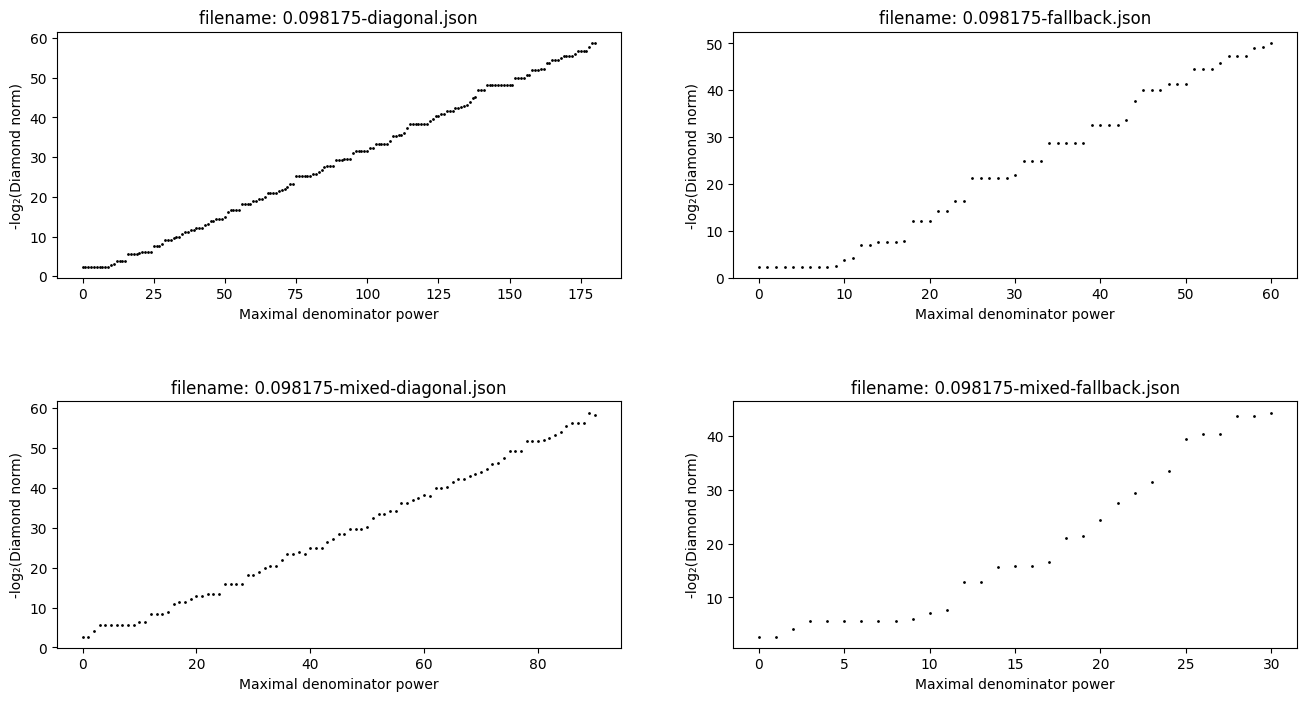

In [12]:
import tarfile
import json
import approximation_math
import matplotlib.pyplot as plt
import math
from mpmath import nstr, mpf, log, ceil
from pandas import DataFrame
import matplotlib.gridspec as gridspec 

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.5)
fig_id = 0
with tarfile.open('clifford-root-t-fourier-angles.tar.gz') as tar:
    for file in tar.getmembers():
        protocol_instances = json.loads(tar.extractfile(file).read().decode())
        if int(ceil(math.pi / mpf(protocol_instances[0]["target_angle"]))) == 32:
            diamond_accuracy = [-log(approximation_math.diamond_error_of(instance), b=2) for instance in protocol_instances]
            fg = plt.subplot(gs[fig_id // 2,fig_id % 2])
            fg.plot(diamond_accuracy, 'ko', markersize=1)
            fg.set(ylabel = '-log₂(Diamond norm)')
            fg.set(xlabel = 'Maximal denominator power')
            fg.set_title("filename: " + file.name)
            fig_id += 1

plt.show(fig)

Note the flat sections in the plots above. This means that algorithm did not find better approximations by using a higher determinant power 
and used a lower power instead. This is illustrated by tables below.

In [13]:
import tarfile
import json
import approximation_math
import matplotlib.pyplot as plt

from mpmath import nstr, mpf, log, ceil
from pandas import DataFrame,set_option
set_option('display.max_rows', 20)
with tarfile.open('clifford-root-t-fourier-angles.tar.gz') as tar:
    for file in tar.getmembers():
        protocol_instances = json.loads(tar.extractfile(file).read().decode())
        if int(ceil(math.pi/mpf(protocol_instances[0]["target_angle"]))) == 32:
            to_print = {"Determinant power bound" : [], "Actual determinant power" : [], "Diamond norm accuracy" : []}
            print(">>>>")
            print("Protocol:", protocol_instances[0]["protocol_name"])
            print("Target angle:", protocol_instances[0]["target_angle"])
            for k in range(len(protocol_instances)):
                protocol_instance = protocol_instances[k]

                to_print["Determinant power bound"] += [k]
                if protocol_instance["protocol_name"] == "fallback" or protocol_instance["protocol_name"] == "mixed fallback":
                    det_powers = [ approximation_math.determinant_power_of(elt["gates"]) for elt in protocol_instance["elements"] if elt["apply_as"] == "projection"]
                else:
                    det_powers = [ approximation_math.determinant_power_of(elt["gates"]) for elt in protocol_instance["elements"]]
                to_print["Actual determinant power"] += [det_powers]
                to_print["Diamond norm accuracy"] += [nstr(approximation_math.diamond_error_of(protocol_instance))]
            display(DataFrame(data = to_print))

>>>>
Protocol: diagonal
Target angle: 0.098174770424681038701957605727484465131161543730472


,Determinant power bound,Actual determinant power,Diamond norm accuracy
0,0,[0],0.1960342806591212
1,1,[0],0.1960342806591212
2,2,[0],0.1960342806591212
3,3,[3],0.1960342806591212
4,4,[3],0.1960342806591212
...,...,...,...
176,176,[174],8.257967902024994e-18
177,177,[177],8.257967902024994e-18
178,178,[178],3.903237582412837e-18
179,179,[179],2.0510238373863842e-18


>>>>
Protocol: fallback
Target angle: 0.098174770424681038701957605727484465131161543730472


,Determinant power bound,Actual determinant power,Diamond norm accuracy
0,0,[0],0.1960342806591212
1,1,[0],0.1960342806591212
2,2,[0],0.1960342806591212
3,3,[3],0.1960342806591212
4,4,[3],0.1960342806591212
...,...,...,...
56,56,[55],6.028819759368773e-15
57,57,[55],6.028819759368773e-15
58,58,[58],1.748805112764234e-15
59,59,[59],1.5493400234570733e-15


>>>>
Protocol: mixed diagonal
Target angle: 0.098174770424681038701957605727484465131161543730472


,Determinant power bound,Actual determinant power,Diamond norm accuracy
0,0,"[0, 0]",0.14956990523274355
1,1,"[0, 0]",0.14956990523274355
2,2,"[0, 2]",0.058020597401857436
3,3,"[0, 3]",0.019214719596769552
4,4,"[0, 3]",0.019214719596769552
...,...,...,...
86,86,"[86, 86]",1.2239044404167213e-17
87,87,"[87, 86]",1.2060436225635856e-17
88,88,"[87, 86]",1.2060436225635856e-17
89,89,"[89, 89]",1.817515107528627e-18


>>>>
Protocol: mixed fallback
Target angle: 0.098174770424681038701957605727484465131161543730472


,Determinant power bound,Actual determinant power,Diamond norm accuracy
0,0,"[0, 0]",0.14956990523274355
1,1,"[0, 0]",0.14956990523274355
2,2,"[0, 2]",0.058020597401857436
3,3,"[0, 3]",0.019214719596769552
4,4,"[0, 3]",0.019214719596769552
...,...,...,...
26,26,"[25, 26]",7.417324494470734e-13
27,27,"[25, 26]",7.417324494470734e-13
28,28,"[25, 28]",6.644425270468795e-14
29,29,"[25, 28]",6.644425270468795e-14


### Range of angles with increasing approximation accuracy

In [14]:
import data_analysis

dataset_file = "clifford-root-t-random-angles.tar.gz"
gate_costs_of = data_analysis.dataset_costs[dataset_file]
display(gate_costs_of)
clifford_t_random_angles_40 = data_analysis.load_all_as_dataframe(dataset_file, gate_costs_of = gate_costs_of, files_limit=80)
data_statistics = data_analysis.statistics_of(clifford_t_random_angles_40, gate_costs_of = gate_costs_of)
display(data_statistics)

{'power': <function approximation_math.determinant_power_of(gates: str) -> int>,
 'rcount': <function approximation_math.rotation_count_of(gates: str) -> int>,
 'tcost': <function approximation_math.t_cost_of(gates: str) -> int>}

,error,protocol,count,power:mean,power:stddev,power:min,power:max,power:q1,power:q2,power:median,...,rcount:q1,rcount:q2,rcount:median,tcost:mean,tcost:stddev,tcost:min,tcost:max,tcost:q1,tcost:q2,tcost:median
0,1.189534e-18,diagonal,3,178.333333,0.577350,178.0,179.0,178.00,178.98,178.0,...,70.02,72.96,71.0,178.333333,8.144528,169.0,184.0,169.26,183.96,182.0
1,1.663817e-18,diagonal,8,179.000000,0.925820,178.0,180.0,178.00,180.00,179.0,...,69.07,73.93,71.0,180.750000,8.548183,169.0,195.0,169.07,194.30,183.0
2,2.327202e-18,diagonal,14,179.285714,0.825420,178.0,180.0,178.00,180.00,179.5,...,69.00,74.87,71.0,181.071429,8.913812,165.0,195.0,165.52,195.00,183.0
3,3.255089e-18,diagonal,19,178.473684,2.037657,172.0,180.0,172.54,180.00,179.0,...,69.00,74.00,71.0,177.421053,8.597905,165.0,195.0,165.18,194.10,177.0
4,4.552935e-18,diagonal,19,176.684211,2.404917,170.0,179.0,170.36,179.00,177.0,...,65.72,71.82,70.0,173.421053,6.423185,163.0,187.0,163.36,186.46,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,2.612675e-01,mixed fallback,20,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0
464,3.654383e-01,mixed fallback,20,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0
465,5.111433e-01,mixed fallback,20,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0
466,7.149429e-01,mixed fallback,20,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,...,0.00,0.00,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0


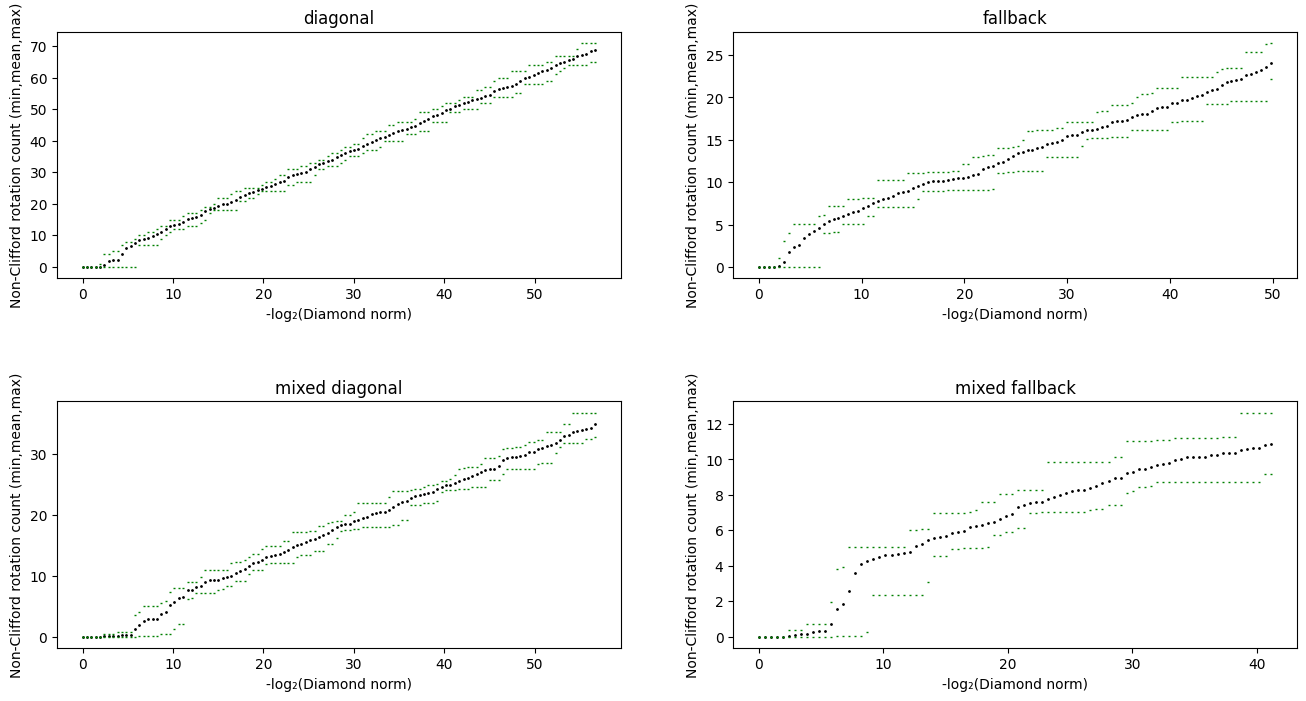

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import math

fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.5)
fig_id = 0

for protocol in { pt for pt in data_statistics["protocol"]} :
    max_count = max(data_statistics["count"])
    plot_data = data_statistics.query(f'count >= {max_count} & protocol == "{protocol}"')
    plot_x = [-math.log(x,2) for x in plot_data["error"]]
    plot_mean = plot_data["rcount:mean"]
    plot_max = plot_data["rcount:max"]
    plot_min = plot_data["rcount:min"]
    fg = plt.subplot(gs[fig_id // 2,fig_id % 2])
    fg.plot(plot_x, plot_mean, 'ko', plot_x, plot_max, 'g_', plot_x, plot_min, 'g_', markersize=1)
    fg.set(ylabel = 'Non-Clifford rotation count (min,mean,max)')
    fg.set(xlabel = '-log₂(Diamond norm)')
    fg.set_title(protocol)
    fig_id += 1

plt.show(fig)

### Reproducing numerical results highlighted in the paper

The code below creates TSV files that then are used in the paper as a source of the figures. Note that this cell is expected to take 2-3 minutes to run.

In [16]:
import data_analysis

files_limit = 8 # change to None to process the datasets completely, it will take a long time
for dataset_file in data_analysis.dataset_costs.keys():
    gate_costs_of = data_analysis.dataset_costs[dataset_file]
    processed_data = data_analysis.load_all_as_dataframe(dataset_file, gate_costs_of = gate_costs_of, files_limit=files_limit)
    processed_data.to_csv(f'{dataset_file.split(".")[0]}-all-rows.tsv', sep = "\t") # save all rows costs and accuracies to tsv
    data_statistics = data_analysis.statistics_of(processed_data, gate_costs_of = gate_costs_of)
    for protocol in { pt for pt in data_statistics["protocol"]} :
        protocol_data = data_statistics.query(f'protocol == "{protocol}"')
        name_with_dashes = protocol.replace(' ', '-')
        protocol_data.to_csv(f'{dataset_file.split(".")[0]}-{name_with_dashes}.tsv', sep = "\t")


#### Generating figures for the paper
We use LaTeX and pgfplots to create the figures from the files obtained using code from the _Reproducing numerical results highlighted in the paper_ section below.
We provide results of calculations from above given they take a long time.

In [17]:
!rm -rf ./data
!rm -rf ./figures
!mkdir data 
!mkdir figures 
!tar -xzvf shorter-quantum-circuits-statistics.tar.gz -C ./data

clifford-root-t-fourier-angles-diagonal.tsv
clifford-root-t-fourier-angles-fallback.tsv
clifford-root-t-fourier-angles-mixed-diagonal.tsv
clifford-root-t-fourier-angles-mixed-fallback.tsv
clifford-root-t-random-angles-diagonal.tsv
clifford-root-t-random-angles-fallback.tsv
clifford-root-t-random-angles-mixed-diagonal.tsv
clifford-root-t-random-angles-mixed-fallback.tsv
clifford-t-fourier-angles-diagonal.tsv
clifford-t-fourier-angles-fallback.tsv
clifford-t-fourier-angles-mixed-diagonal.tsv
clifford-t-fourier-angles-mixed-fallback.tsv
clifford-t-random-angles-diagonal.tsv
clifford-t-random-angles-fallback.tsv
clifford-t-random-angles-mixed-diagonal.tsv
clifford-t-random-angles-mixed-fallback.tsv


In [18]:
# Generate figures using pdflatex if it is available in the environment
import os
os.system('pdflatex -quiet -enable-write18 --extra-mem-bot=10000000 figures-generation.tex -output-directory=figures')

0

#### Costs as a function of diamond norm accuracy averaged over the datasets

Below are `matplotlib` versions of the figures presented in the paper. 
In addition, we show linear fits for mean and max cost over the random angles dataset used for Table 1 in the paper.

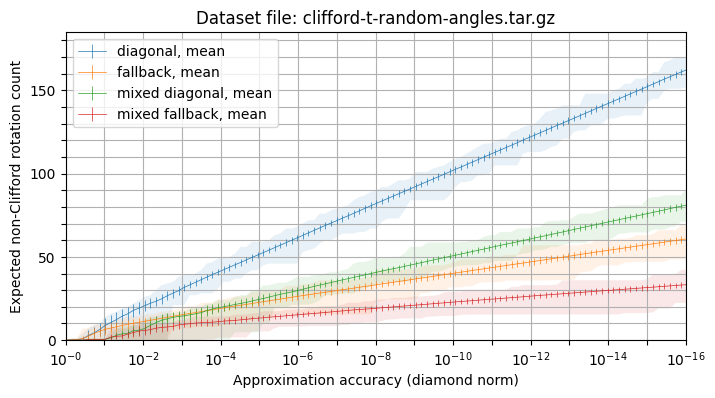

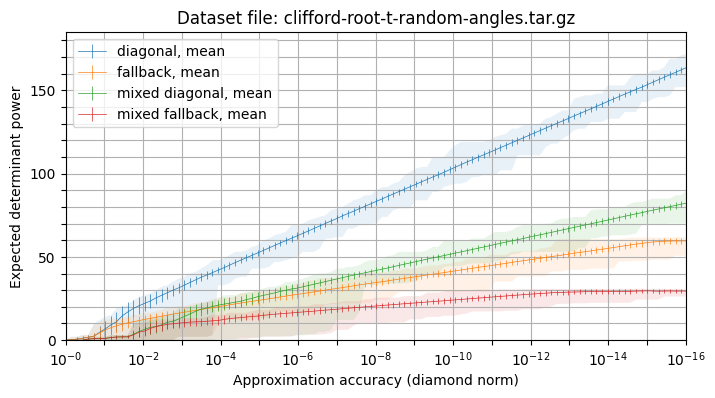

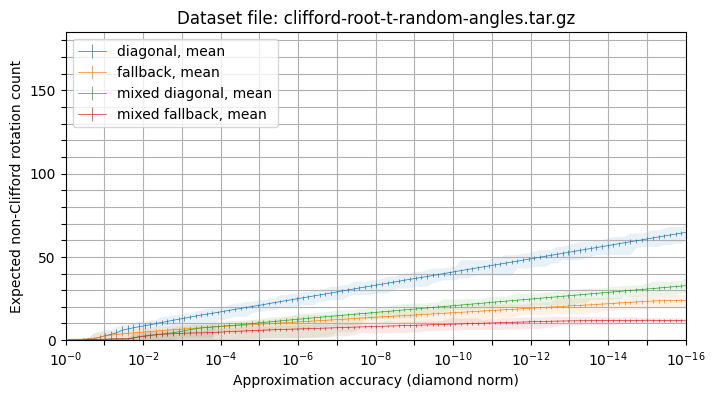

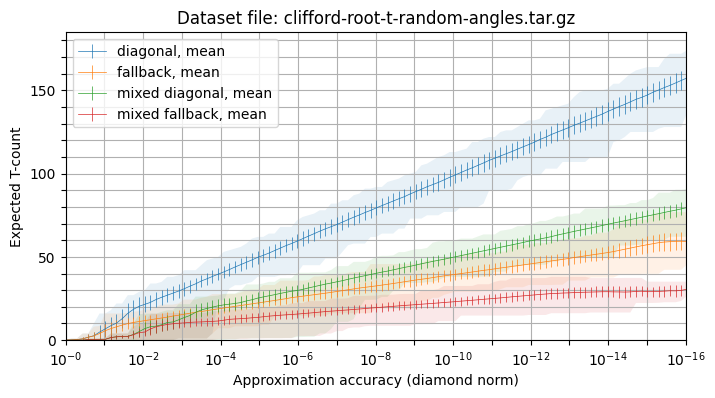

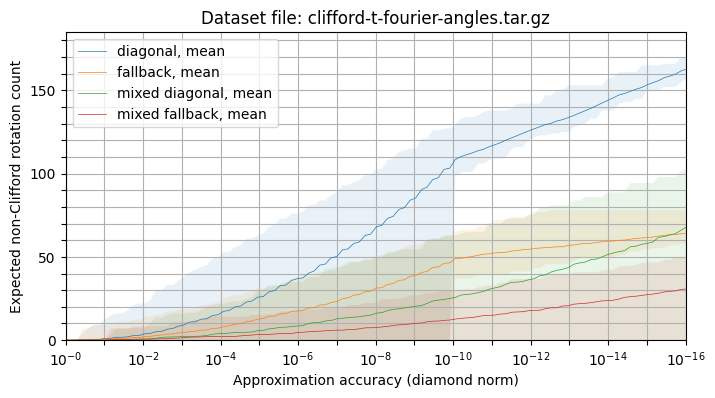

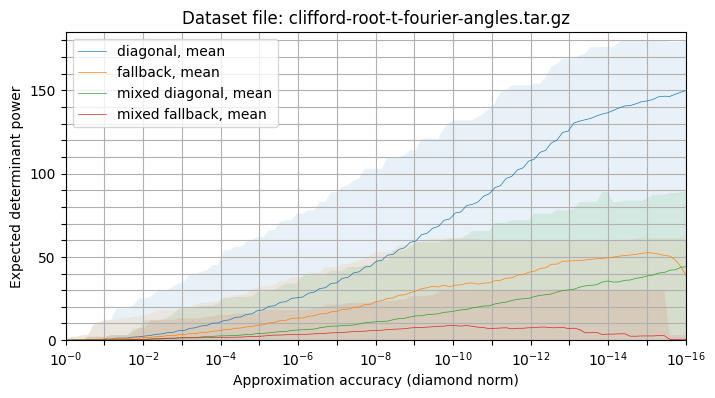

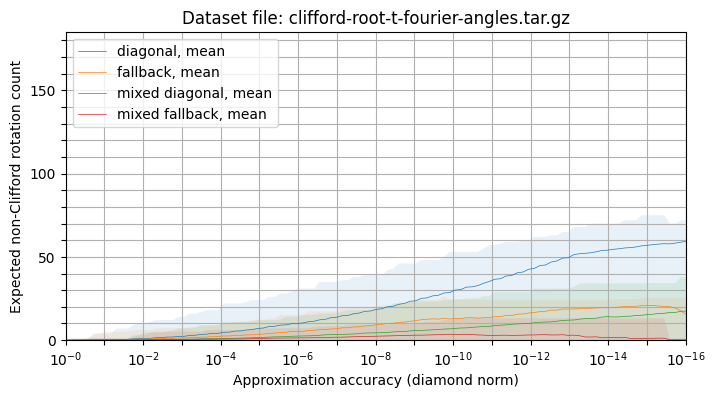

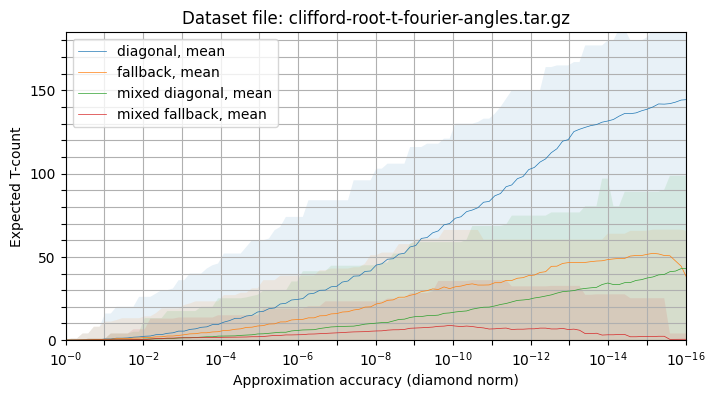

In [19]:
import matplotlib.pyplot as plt
import pandas
import math
import data_analysis

cost_labels = {"rcount":"non-Clifford rotation count","tcost" : "T-count", "power" : "determinant power" }
files_limit = 8 # change to None to process the datasets completely, it will take a long time
for dataset_file in ["clifford-t-random-angles.tar.gz","clifford-root-t-random-angles.tar.gz","clifford-t-fourier-angles.tar.gz","clifford-root-t-fourier-angles.tar.gz"]:
    gate_costs_of = data_analysis.dataset_costs[dataset_file]
    
    for cost in gate_costs_of:
        fig, ax = plt.subplots(figsize=(8, 4))
        for protocol in [ "diagonal", "fallback", "mixed diagonal", "mixed fallback" ] :
            name_with_dashes = protocol.replace(' ', '-')
            protocol_data = pandas.read_csv(f'./data/{dataset_file.split(".")[0]}-{name_with_dashes}.tsv', sep = "\t", header=0, index_col=0)
            log_error = [math.log(x, 0.1) for x in protocol_data["error"]]
            if dataset_file.endswith('random-angles.tar.gz'):
                plt.errorbar(log_error, protocol_data[cost + ":mean"], yerr=protocol_data[cost + ":stddev"], label=protocol + ", mean", linewidth = 0.5)
            else:
                plt.plot(log_error, protocol_data[cost + ":mean"], label=protocol + ", mean", linewidth=0.5)
            plt.fill_between(log_error, protocol_data[cost + ":min"], protocol_data[cost + ":max"], alpha=0.1)
            
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.xticks(range(0,17),[f'$10^{{-{x}}}$' if x % 2 == 0 else '' for x in range(0,17)])
        plt.yticks(range(0,200,10),[x if x % 50 == 0 else '' for x in range(0,200,10)])
        plt.xlabel('Approximation accuracy (diamond norm)')
        plt.ylabel('Expected ' + cost_labels[cost])
        ax.set_xlim(0, 16)
        ax.set_ylim(0, 185)
        ax.set_title('Dataset file: ' + dataset_file)
        plt.show()

In [20]:
import matplotlib.pyplot as plt
import pandas
import math
import data_analysis

res = []
cost_labels = {"rcount":"non-Clifford rotation count","tcost" : "T-count", "power" : "determinant power" }
files_limit = 8 # change to None to process the datasets completely, it will take a long time
for dataset_file in ["clifford-t-random-angles.tar.gz","clifford-root-t-random-angles.tar.gz","clifford-t-fourier-angles.tar.gz","clifford-root-t-fourier-angles.tar.gz"]:
    gate_costs_of = data_analysis.dataset_costs[dataset_file]
    if dataset_file.endswith('random-angles.tar.gz'):
        for cost in gate_costs_of:
            for protocol in [ "diagonal", "fallback", "mixed diagonal", "mixed fallback" ] :
                name_with_dashes = protocol.replace(' ', '-')
                protocol_data = pandas.read_csv(f'./data/{dataset_file.split(".")[0]}-{name_with_dashes}.tsv', sep = "\t", header=0, index_col=0)
                max_count = max([x for x in protocol_data["count"]])
                filtered_data = protocol_data.query(f"error < {1e-2} & count == {max_count}")
                param, cov = data_analysis.best_fit_parameters_of(filtered_data, cost_column = cost)
                param_max, cov_max = data_analysis.best_fit_parameters_of(filtered_data, cost_column = cost + ":max", use_sigmas=False)
                param_min, cov_min = data_analysis.best_fit_parameters_of(filtered_data, cost_column = cost + ":min", use_sigmas=False)
                param_median, cov_median = data_analysis.best_fit_parameters_of(filtered_data, cost_column = cost + ":median", use_sigmas=False)
                dataset_name = dataset_file.split(".")[0]
                res.append({"dataset (cost)":f"{dataset_name} ({cost})",
                    "protocol":protocol,
                    "mean cost fit":f"{param[0]:.2f}log₂(1/ε)+{param[1]:.2f}",
                    "mean cost fit stddev":f"({cov[0,0]:.2e}, {cov[1,1]:.2e})",
                    "max cost fit":f"{param_max[0]:.2f}log₂(1/ε)+{param_max[1]:.2f}",
                    "max cost fit stddev":f"({cov_max[0,0]:.2e}, {cov_max[1,1]:.2e})",
                    "min cost fit":f"{param_min[0]:.2f}log₂(1/ε)+({param_min[1]:.2f})",
                    "median cost fit":f"{param_median[0]:.2f}log₂(1/ε)+{param_median[1]:.2f}",
                    })

display(pandas.DataFrame(res).groupby("dataset (cost)",group_keys=True).apply(lambda a: a.drop(["dataset (cost)"], axis=1)[:]))               
            

protocol  \
dataset (cost)                                              
clifford-root-t-random-angles (power)  4         diagonal   
                                       5         fallback   
                                       6   mixed diagonal   
                                       7   mixed fallback   
clifford-root-t-random-angles (rcount) 8         diagonal   
                                       9         fallback   
                                       10  mixed diagonal   
                                       11  mixed fallback   
clifford-root-t-random-angles (tcost)  12        diagonal   
                                       13        fallback   
                                       14  mixed diagonal   
                                       15  mixed fallback   
clifford-t-random-angles (rcount)      0         diagonal   
                                       1         fallback   
                                       2   mixed diagonal   
                                       3   mixed fallback   

                                                 mean cost fit  \
dataset (cost)                                                   
clifford-root-t-random-angles (power)  4    3.03log₂(1/ε)+2.56   
                                       5    1.06log₂(1/ε)+6.30   
                                       6    1.55log₂(1/ε)+0.36   
                                       7    0.60log₂(1/ε)+4.41   
clifford-root-t-random-angles (rcount) 8    1.20log₂(1/ε)+1.04   
                                       9    0.42log₂(1/ε)+2.54   
                                       10   0.62log₂(1/ε)+0.01   
                                       11   0.24log₂(1/ε)+1.71   
clifford-root-t-random-angles (tcost)  12   2.93log₂(1/ε)+1.34   
                                       13   1.02log₂(1/ε)+5.37   
                                       14  1.51log₂(1/ε)+-0.39   
                                       15   0.58log₂(1/ε)+4.06   
clifford-t-random-angles (rcount)      0    3.02log₂(1/ε)+1.57   
                                       1    1.04log₂(1/ε)+5.47   
                                       2   1.52log₂(1/ε)+-0.05   
                                       3    0.54log₂(1/ε)+4.51   

                                           mean cost fit stddev  \
dataset (cost)                                                    
clifford-root-t-random-angles (power)  4   (2.17e-04, 2.89e-01)   
                                       5   (4.14e-04, 3.55e-01)   
                                       6   (3.21e-04, 4.49e-01)   
                                       7   (1.11e-03, 6.82e-01)   
clifford-root-t-random-angles (rcount) 8   (7.94e-05, 8.77e-02)   
                                       9   (9.95e-05, 7.81e-02)   
                                       10  (7.50e-05, 9.50e-02)   
                                       11  (2.14e-04, 1.27e-01)   
clifford-root-t-random-angles (tcost)  12  (1.09e-03, 1.05e+00)   
                                       13  (1.08e-03, 7.58e-01)   
                                       14  (7.79e-04, 8.58e-01)   
                                       15  (1.80e-03, 9.42e-01)   
clifford-t-random-angles (rcount)      0   (3.24e-05, 1.12e-01)   
                                       1   (4.52e-05, 1.21e-01)   
                                       2   (3.52e-05, 1.25e-01)   
                                       3   (5.77e-05, 1.25e-01)   

                                                  max cost fit  \
dataset (cost)                                                   
clifford-root-t-random-angles (power)  4    3.09log₂(1/ε)+7.66   
                                       5   1.13log₂(1/ε)+10.10   
                                       6    1.62log₂(1/ε)+3.67   
                                       7    0.70log₂(1/ε)+6.20   
clifford-root-t-random-angles (rcount) 8    1.24log₂(1/ε)+3.41   
                                       9    0.46log₂(1/ε)+4.55   
                          

Above results are used in [Resource Estimation](https://github.com/microsoft/Quantum/blob/main/samples/azure-quantum/resource-estimation/README.md) notebooks and in the related [paper](https://arxiv.org/pdf/2211.07629.pdf).